In [146]:
#data preparation
import pandas as pd
import cv2
import matplotlib.pyplot as plt
import numpy as np

In [152]:
#학습된 모델 로드
import geffnet
import torch.nn as nn
import torch
from torchvision import transforms
model = geffnet.create_model('efficientnet_b2', pretrained=True)
model.classifier = nn.Sequential(
        nn.Linear(1408,512),
        nn.ReLU(),
        nn.Dropout(p=0.4),
        nn.Linear(512,128),
        nn.ReLU(),
        nn.Dropout(p=0.4),
        nn.Linear(128,8))
model.load_state_dict(torch.load("model.pt"))
model.eval()

GenEfficientNet(
  (conv_stem): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
  (bn1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (act1): SiLU(inplace=True)
  (blocks): Sequential(
    (0): Sequential(
      (0): DepthwiseSeparableConv(
        (conv_dw): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=32, bias=False)
        (bn1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (act1): SiLU(inplace=True)
        (se): SqueezeExcite(
          (conv_reduce): Conv2d(32, 8, kernel_size=(1, 1), stride=(1, 1))
          (act1): SiLU(inplace=True)
          (conv_expand): Conv2d(8, 32, kernel_size=(1, 1), stride=(1, 1))
        )
        (conv_pw): Conv2d(32, 16, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn2): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (act2): Identity()
      )
      (1): Depthwise

In [55]:
# 인플루언서 이미지 (각 10개씩) 를 model 에 통과시켰을 때 얻어지는 1x8 벡터를 저장한다.
# 인플루언서 100명, 각 이미지 10개, 8차원 벡터 이므로 => (100,10,8) 의 output 이 얻어진다.

import os
import pandas as pd

#get influencer name list
influencer_list = pd.read_csv('influencer_list.csv')
influencer_list['id']

result_vector_list = np.array([[]]) #각 influencer 의 'n*8 influencer embedding' 
influencer_color_list = [] #각 influencer 의 personal color

for influencer_id in influencer_list['id']:
    folder_path = 'C:/Users/wjdth/kuiai/data/influencer_imgs/'+influencer_id+'/images/'
    current_vector_list = []
    current_color_list = [0 for i in range(8)]
    i = 0
    for f_name in os.listdir(folder_path):
        if f_name.endswith(('.jpg','.webp')): #2가지 형식의 이미지
            try:
                file_path = folder_path + f_name
                data = cv2.imread(file_path)
                data = cv2.resize(data, (224,224),interpolation = cv2.INTER_AREA)
                data = torch.from_numpy(data).float()
                data = torch.reshape(data,(1,3,224,224))
                output = model(data) #1x8 vector
                current_vector_list.append(output.detach().numpy())
                # convert output probabilities to predicted class
                _, pred = torch.max(output, 1)
                current_color_list[pred] += 1
                i+=1
                if i>=10 : break #각 10장만 저장
            except:
                print('error')
                continue
            
    max_color_idx = current_color_list.index(max(current_color_list))
    influencer_color_list.append(max_color_idx)
    if np.array(current_vector_list).shape == (10,1,8):
        result_vector_list = np.append(result_vector_list,current_vector_list)    
    else:
        print(influencer_id,np.array(current_vector_list).shape)

In [157]:
# (100,10,8) 로 reshape
result_vector_list = np.array(result_vector_list) #(8000,)
influencer_color_list = np.array(influencer_color_list) #(100,)
result_vector_list = result_vector_list.reshape((100,10,8))

In [145]:
#인플루언서 벡터 결과 저장 - 추후 데모 앱에서 사용하기 위함
np.save('result_vector_list.npy',result_vector_list)
np.save('influencer_color_list.npy',influencer_color_list)
#result_vector_list = np.load('result_vector_list.npy')
#influencer_color_list = np.load('influencer_color_list.npy')

In [155]:
# 사용자 이미지 로드
user_img = cv2.imread('minji_1.jpeg')
user_img = cv2.resize(user_img,dsize=None,fx=1.0,fy=1.0)
gray = cv2.cvtColor(user_img, cv2.COLOR_BGR2GRAY)

# cascade 얼굴 탐지 알고리즘 # face detection 으로 얼굴 범위 특정
#https://deep-eye.tistory.com/18#google_vignette
cascade_filename = 'haarcascade_frontalface_alt.xml' # 가중치 파일 경로
cascade = cv2.CascadeClassifier(cascade_filename) # 모델 불러오기
results = cascade.detectMultiScale(gray,            # 입력 이미지
                                   scaleFactor= 1.5,# 이미지 피라미드 스케일 factor
                                   minNeighbors=5,  # 인접 객체 최소 거리 픽셀
                                   minSize=(20,20)  # 탐지 객체 최소 크기
                                   )            
# 결과값 = 탐지된 객체의 경계상자 list                                                                           
for box in results:
    x, y, w, h = box # 좌표 추출
    cv2.rectangle(user_img, (x,y), (x+w, y+h), (255,255,255), thickness=2) # 경계 상자 그리기
cv2.imwrite('minji1_bbox.jpg',user_img)

cropped_img = user_img[y:y+h,x:x+w]
cv2.imwrite('minji_1_cropped.jpg',cropped_img)
data = cv2.resize(cropped_img, (224,224),interpolation = cv2.INTER_AREA)
data = torch.from_numpy(data).float()
data = torch.reshape(data,(1,3,224,224))

# 1x8 user vector 를 얻는다
output = model(data) #1x8 vector
user_vector = output.detach().numpy()
_, user_cls = torch.max(output, 1)
print(user_vector.shape, idx_to_color[user_cls.item()])

(1, 8) 봄웜라이트


In [37]:
# result_vector_list.shape => (100,10,8)
# result_vector_list.transpose(1,2,0).shape => (10,8,100)

# 유저 벡터와 인플루언서 벡터 사이의 유사도 계산 => matrix multiplication
scores_list = np.matmul(user_vector,result_vector_list.transpose(1,2,0)) 
scores_list = scores_list.reshape((10,100))
scores_list.shape

(10, 100)

In [40]:
# 각 인플루언서 별 10차원 스코어 벡터 -> 합을 구해서 최종 스코어 도출
final_scores_list = sum(scores_list)
final_scores_list.shape

(100,)

In [49]:
# 각 인플루언서의 최종 스코어의 형태는 다음과 같다.
final_scores_list

array([22.40813791, 39.37053958, 42.12193546, 40.81606346, 37.94468994,
       41.37260701, 43.32236577, 37.95874402, 42.3664188 , 37.19820912,
       40.01472249, 47.18641706, 42.1514529 , 42.78188778, 43.33450553,
       39.68250718, 47.2969038 , 38.96303783, 44.50240924, 41.74459924,
       58.5446376 , 42.59314544, 37.8272051 , 43.22657666, 35.83531789,
       42.36787846, 52.26280389, 45.24949713, 54.48749075, 40.7108159 ,
       47.10727214, 40.44215874, 45.48715356, 40.73969815, 42.48172718,
       37.59307781, 53.11194836, 33.79556022, 45.78541131, 40.76859159,
       48.45852047, 42.97044304, 49.86636776, 39.7788998 , 51.882459  ,
       35.91782907, 37.10172804, 47.2330191 , 37.14751905, 30.84513644,
       35.49332371, 48.33584526, 49.28436766, 49.03556757, 53.0741995 ,
       58.04031347, 41.16649124, 46.88101842, 50.31997918, 50.34109426,
       47.18240558, 41.80109375, 44.30547533, 37.97085426, 45.43849222,
       43.78610817, 48.89393834, 54.60766808, 40.97637881, 46.17

In [57]:
# 인덱스 - 클래스 매핑
idx_to_color = {
    0: "봄웜브라이트",
    1: "봄웜라이트",
    2: "여름쿨라이트",
    3: "여름쿨뮤트",
    4: "가을웜뮤트",
    5: "가을웜딥",
    6: "겨울쿨딥",
    7: "겨울쿨브라이트"
}

In [71]:
#code ref: https://stackoverflow.com/questions/6910641/how-do-i-get-indices-of-n-maximum-values-in-a-numpy-array
def largest_indices(ary, n):
    """Returns the n largest indices from a numpy array."""
    flat = ary.flatten()
    indices = np.argpartition(flat, -n)[-n:]
    indices = indices[np.argsort(-flat[indices])]
    return np.unravel_index(indices, ary.shape)

# 가장 스코어가 높은 인플루언서 3명 선정. 추가 정보로 인플루언서의 퍼스널컬러를 제공.
influencer_idxs = largest_indices(final_scores_list,3)
influencer_names = [influencer_list['id'][idx] for idx in influencer_idxs]
influencer_colors = [idx_to_color[influencer_color_list[idx]] for idx in influencer_idxs[0]]
influencer_names,influencer_colors

([20     @y_mood_h
  55    @so_h_appy
  86    @hwi____ii
  Name: id, dtype: object],
 ['봄웜라이트', '봄웜라이트', '가을웜뮤트'])

C:\Users\wjdth\AppData\Local\Temp\ipykernel_3968\3424641549.py:16: MatplotlibDeprecationWarning: Auto-removal of grids by pcolor() and pcolormesh() is deprecated since 3.5 and will be removed two minor releases later; please call grid(False) first.
  plt.colorbar()


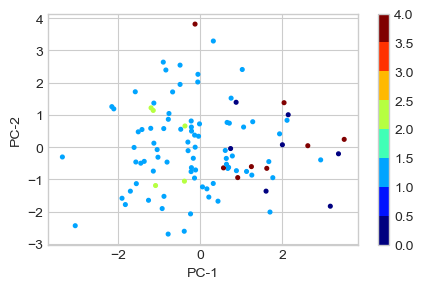

In [142]:
#result vector list 시각화
#PCA ref: https://www.askpython.com/python/examples/principal-component-analysis-for-image-data
from sklearn.decomposition import PCA

result_vector_list = result_vector_list.reshape((100,80))

pca = PCA(2) # we need 2 principal components.
converted_data = pca.fit_transform(result_vector_list)
converted_data.shape

plt.style.use('seaborn-whitegrid')
plt.figure(figsize = (5,3))
c_map = plt.cm.get_cmap('jet', 8)
plt.scatter(converted_data[:, 0], converted_data[:, 1], s = 7,
            cmap = c_map , c = influencer_color_list)
plt.colorbar()
plt.xlabel('PC-1') , plt.ylabel('PC-2')
plt.show()

In [ ]:
folder_path = 'C:/Users/wjdth/kuiai/data/train/'
for f_name in os.listdir(folder_path):
    img_path = folder_path + f_name
    for i,color_name in enumerate(search_q_list):
        if color_name in f_name:
            writer.writerow([img_path,i])

In [156]:
import os
import pandas as pd
import shutil

search_q_list = ["봄웜브라이트 코디","봄웜라이트 코디","여름쿨라이트 코디","여름쿨뮤트 코디",
                 "가을웜뮤트 코디","가을웜딥 코디","겨울쿨딥 코디","겨울쿨브라이트 코디"]

root_path = "C:/Users/wjdth/kuiai/data/color_Images/"
new_root_path = "C:/Users/wjdth/kuiai/data/new_eng_images/"
vector_list = []
color_list = []
i = 0
for f_name in os.listdir(root_path):
    if f_name.endswith(('.jpg','.webp')):
        try:
            img_path = root_path+f_name
            new_img_path = new_root_path+str(i)+".jpg"
            shutil.copy(img_path, new_img_path)
            data = cv2.imread(new_img_path)
            data = cv2.resize(data, (224,224),interpolation = cv2.INTER_AREA)
            data = torch.from_numpy(data).float()
            data = torch.reshape(data,(1,3,224,224))
            output = model(data) #1x8 vector
            vector_list.append(output.detach().numpy())
            _, pred = torch.max(output, 1)
            color_list.append(pred)
        except:
            print('error')
            continue
        i+=1

In [126]:
vector_list = np.array(vector_list)
color_list = np.array(color_list)
vector_list.shape, color_list.shape

C:\Users\wjdth\AppData\Local\Temp\ipykernel_3968\958032152.py:2: FutureWarning: The input object of type 'Tensor' is an array-like implementing one of the corresponding protocols (`__array__`, `__array_interface__` or `__array_struct__`); but not a sequence (or 0-D). In the future, this object will be coerced as if it was first converted using `np.array(obj)`. To retain the old behaviour, you have to either modify the type 'Tensor', or assign to an empty array created with `np.empty(correct_shape, dtype=object)`.
  color_list = np.array(color_list)
C:\Users\wjdth\AppData\Local\Temp\ipykernel_3968\958032152.py:2: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  color_list = np.array(color_list)


((180, 1, 8), (180,))

C:\Users\wjdth\AppData\Local\Temp\ipykernel_3968\2195391014.py:16: MatplotlibDeprecationWarning: Auto-removal of grids by pcolor() and pcolormesh() is deprecated since 3.5 and will be removed two minor releases later; please call grid(False) first.
  plt.colorbar()


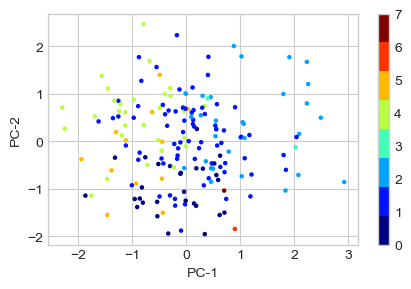

In [141]:
#result vector list 시각화
#PCA ref: https://www.askpython.com/python/examples/principal-component-analysis-for-image-data
from sklearn.decomposition import PCA

vector_list = vector_list.reshape((180,8))

pca = PCA(2) # we need 2 principal components.
converted_data = pca.fit_transform(vector_list)
converted_data.shape

plt.style.use('seaborn-whitegrid')
plt.figure(figsize = (5,3))
c_map = plt.cm.get_cmap('jet', 8)
plt.scatter(converted_data[:, 0], converted_data[:, 1], s = 5,
            cmap = c_map , c = color_list)
plt.colorbar()
plt.xlabel('PC-1') , plt.ylabel('PC-2')
plt.show()